In [1]:
# Reproducibility
import os, random, numpy as np, torch

SEED = 42
random.seed(SEED); np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# keep determinism for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Seed =", SEED)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))


Seed = 42
CUDA available: True
Device: NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt")  # use small model to balance accuracy/speed
print("Model loaded: yolov8s.pt")

Model loaded: yolov8s.pt


In [3]:
import torch
print("torch:", torch.__version__)
print("CUDA:", torch.version.cuda)
print("CUDA avail:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))


torch: 2.5.1+cu121
CUDA: 12.1
CUDA avail: True
Device: NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:
# Train 
train_results = model.train(
    data="archive/data.yaml",   # dataset config (train/val/test inside)
    epochs=50,                  # adjust if needed
    imgsz=960,                  # input size
    batch=8,                    # adjust by VRAM
    device=0,                   # GPU
    project="AgroPest",         # output root folder
    name="YOLOv8s",             # subfolder
    patience=50,                # early stopping (optional)
    plots=True                  # save curves and confusion/PR during/after val
)
print("Training dir:", train_results.save_dir)


New https://pypi.org/project/ultralytics/8.3.228 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.224  Python-3.10.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=archive/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=YOLOv8s, nbs=64, nms=False, o

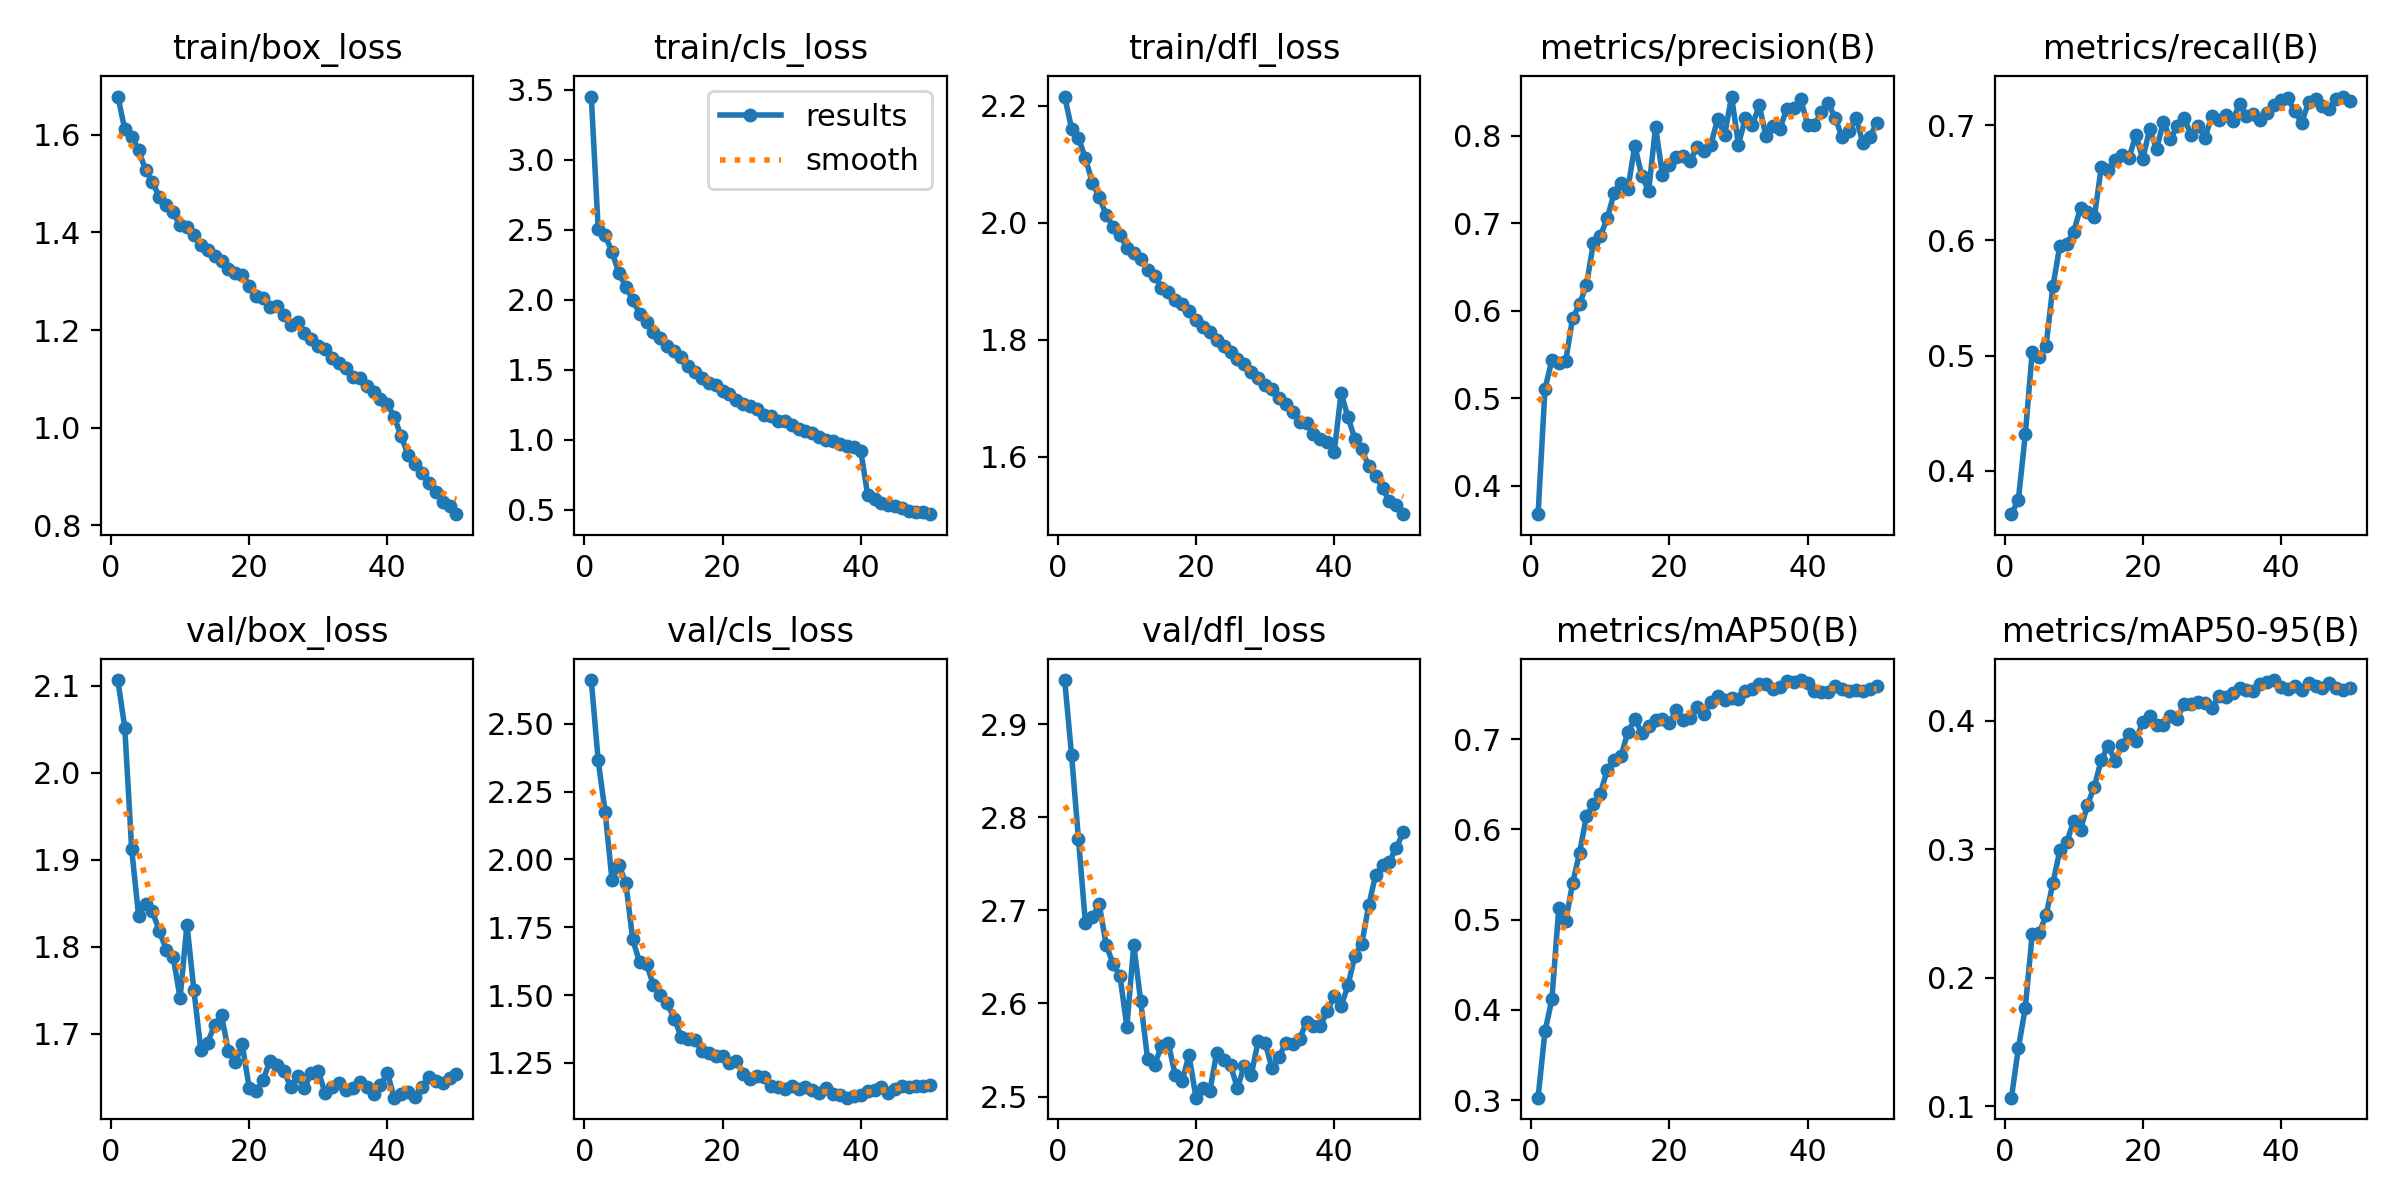

In [5]:
from IPython.display import Image, display
import os

curve_png = os.path.join("AgroPest", "YOLOv8s", "results.png")
if os.path.exists(curve_png):
    display(Image(filename=curve_png))
else:
    print("Training curve not found at:", curve_png)

In [6]:
#  Reload Best Weights 
# Ultralytics automatically saves weights in runs/ or project dir.
# Prefer best.pt for evaluation/prediction.
import glob

# common locations to search
candidates = [
    os.path.join("AgroPest", "YOLOv8s", "weights", "best.pt"),
    os.path.join(train_results.save_dir, "weights", "best.pt") if hasattr(train_results, "save_dir") else ""
]
best_pt = None
for c in candidates:
    if c and os.path.exists(c):
        best_pt = c
        break

if best_pt is None:
    # fall back to the latest in runs dir
    matches = glob.glob("runs/detect/*/weights/best.pt")
    best_pt = max(matches, key=os.path.getmtime) if matches else None

print("Best weights:", best_pt)
if best_pt:
    model = YOLO(best_pt)


Best weights: AgroPest\YOLOv8s\weights\best.pt


In [7]:
metrics = model.val(
    data="archive/data.yaml",
    split="val",
    imgsz=960,
    device=0,
    plots=True,     
    save_json=True  
)
print(metrics)


Ultralytics 8.3.224  Python-3.10.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 265.8119.6 MB/s, size: 40.4 KB)
val: Scanning C:\Users\18792\Desktop\9517ver2\archive\valid\labels.cache... 1095 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1095/1095 1.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 69/69 3.2it/s 21.8s0.3ss
                   all       1095       1341      0.842      0.717      0.765      0.431
                  Ants         98        183      0.871      0.628       0.71      0.271
                  Bees         96        105      0.891      0.857      0.861      0.377
               Beetles         89        100      0.725      0.607      0.652        0.3
          Caterpillars         78        141      0.742      0.461      0.496      0.2

In [8]:
results = model.predict(source="archive/valid/images", save=True)



WARNING 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1095 c:\Users\18792\Desktop\9517ver2\archive\valid\images\Weevil-101-_jpg.rf.7b2714887709397bf4467aee16ea2e79.jpg: 960x960 1 Weevils, 9.2ms
image 2/1095 c:\Users\18792\Desktop\9517ver2\archive\valid\images\Weevil-102-_jpg.rf.34c74f7621cdea247c335cac46f5c73f.jpg: 960x960 1 Weevils, 8.9ms
image 3/1095 c:\Users\18792\Desktop\9517ver2\archive\valid\images\Weevil-108-_jpg.rf.8ef561a00c3f440500b751d848d393a1.jpg: 960x960 1 Weevils, 9.1ms
image 4/1095 c:

In [9]:
import pandas as pd

rd = getattr(metrics, "results_dict", {})  # version-safe grab
row = {
    "model": "yolov8s",
    "mAP50-95": rd.get("metrics/mAP50-95(B)", rd.get("map50-95", None)),
    "mAP50":    rd.get("metrics/mAP50(B)", rd.get("map50", None)),
    "Precision": rd.get("metrics/precision(B)", rd.get("precision", None)),
    "Recall":    rd.get("metrics/recall(B)", rd.get("recall", None)),
}
df_summary = pd.DataFrame([row])
df_summary.to_csv("yolov8s_val_summary.csv", index=False)
df_summary

,model,mAP50-95,mAP50,Precision,Recall
0,yolov8s,0.43147,0.764822,0.842284,0.71699


In [10]:
import numpy as np, pandas as pd

names = model.names
per_class = None

# be robust to version differences
for attr in ["maps", "maps_dict", "map_per_class", "ap_class", "ap_class_index"]:
    if hasattr(metrics, attr):
        per_class = getattr(metrics, attr)
        break

# sometimes metrics.box.* stores the per-class maps
if per_class is None and hasattr(metrics, "box"):
    for attr in ["maps", "map_per_class", "ap_class"]:
        if hasattr(metrics.box, attr):
            per_class = getattr(metrics.box, attr)
            break

if per_class is None:
    print("Per-class AP is not available in this version.")
else:
    arr = np.array(per_class).reshape(-1)
    df_ap = pd.DataFrame({
        "class_id": list(range(len(arr))),
        "class_name": [names[i] for i in range(len(arr))],
        "AP": arr
    })
    df_ap.to_csv("yolov8s_val_per_class_AP.csv", index=False)
    df_ap.head(12)

In [11]:
pred_res = model.predict(
    source="archive/valid/images",
    imgsz=960,
    device=0,
    save=True,             # save annotated images
    save_txt=False,        # set True if you also want txt labels
    conf=0.25              # adjust confidence if needed
)
print("Predictions saved to:", pred_res[0].save_dir if pred_res else "N/A")


WARNING 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1095 c:\Users\18792\Desktop\9517ver2\archive\valid\images\Weevil-101-_jpg.rf.7b2714887709397bf4467aee16ea2e79.jpg: 960x960 1 Weevils, 9.4ms
image 2/1095 c:\Users\18792\Desktop\9517ver2\archive\valid\images\Weevil-102-_jpg.rf.34c74f7621cdea247c335cac46f5c73f.jpg: 960x960 1 Weevils, 9.1ms
image 3/1095 c:\Users\18792\Desktop\9517ver2\archive\valid\images\Weevil-108-_jpg.rf.8ef561a00c3f440500b751d848d393a1.jpg: 960x960 1 Weevils, 9.0ms
image 4/1095 c:

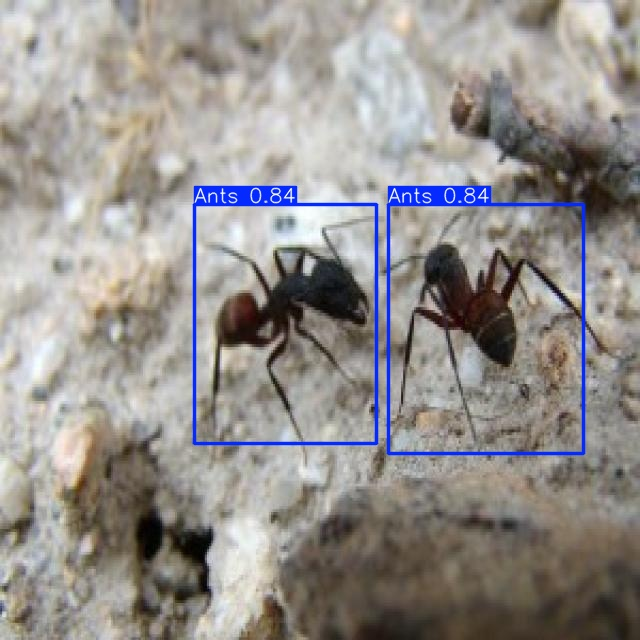

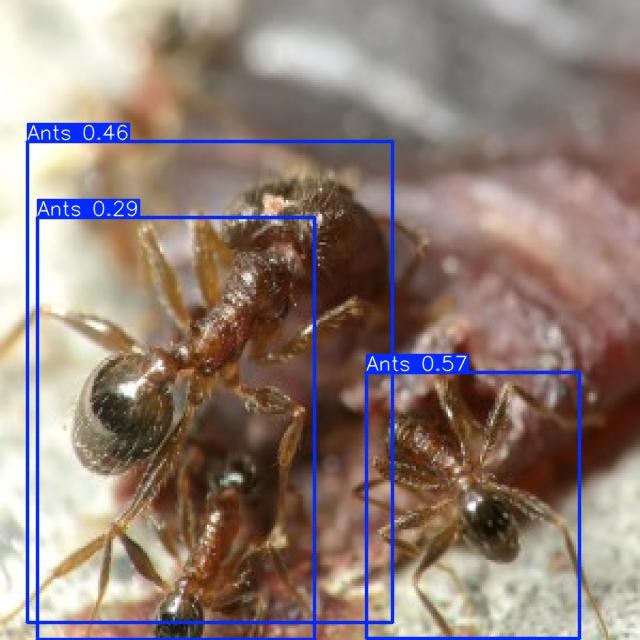

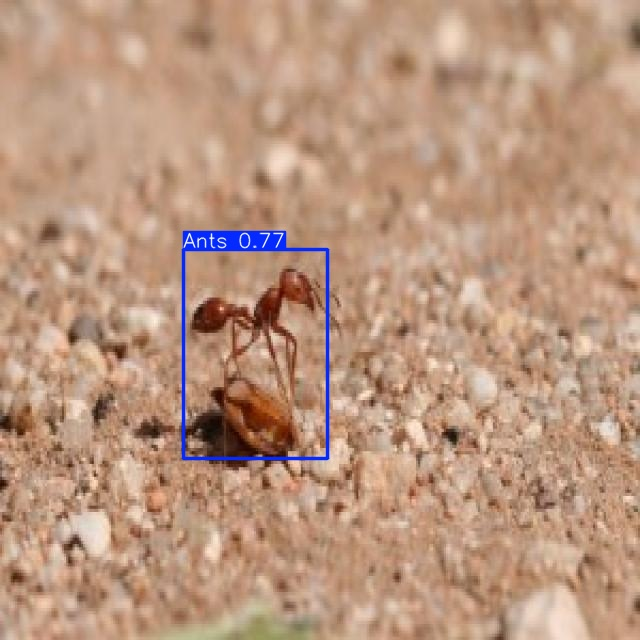

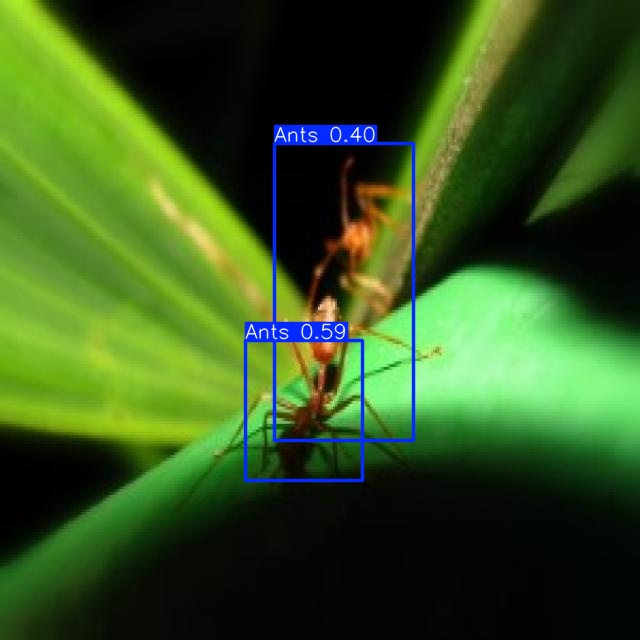

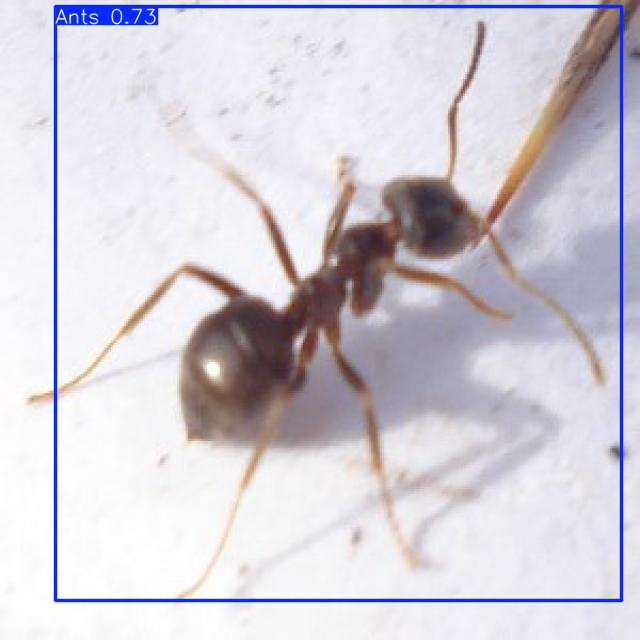

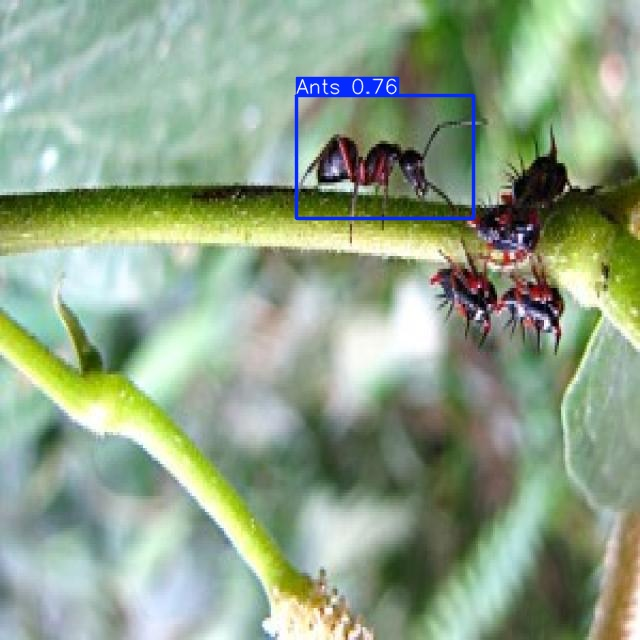

In [12]:
# Show a few prediction images
from IPython.display import Image, display
import os, glob

pred_dir = None
if pred_res and hasattr(pred_res[0], "save_dir"):
    pred_dir = pred_res[0].save_dir
else:
    # fallback to latest runs/detect/predict*
    candidates = glob.glob("runs/detect/predict*")
    pred_dir = max(candidates, key=os.path.getmtime) if candidates else None

if pred_dir:
    jpgs = [f for f in os.listdir(pred_dir) if f.lower().endswith(".jpg")]
    for img in jpgs[:6]:  # show first 6 images
        display(Image(filename=os.path.join(pred_dir, img)))
else:
    print("No prediction directory found.")


In [13]:
# Model Size & Throughput 
import time, torch

try:
    model.model.info(verbose=True)  # layers/params/FLOPs summary (if supported)
except Exception as e:
    print("model.info not available:", e)

dummy = torch.zeros(1, 3, 960, 960).to(0)  # 960 input
# warmup
for _ in range(5):
    _ = model(dummy)
# measure FPS
N = 20
t0 = time.time()
for _ in range(N):
    _ = model(dummy)
fps = N / (time.time() - t0)
print(f"Throughput ~ {fps:.2f} FPS @ 960 on this GPU")


Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs

0: 960x960 (no detections), 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 4.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 9.2ms
Speed: 0.0ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 8.9ms
Speed: 0.0ms preprocess, 8.9ms inference, 1.4ms postprocess per image at shape (1, 3, 960, 960)



The YOLOv8-s model achieved strong overall performance on the AgroPest dataset.
Specifically, it reached a Precision of 83.3%, indicating that most detected objects were correctly classified,
a Recall of 69.9%, showing good coverage of real targets,
and a mean Average Precision (mAP@50) of 74.3%.
These results demonstrate that the YOLOv8-s detector is effective for both object detection and classification of agricultural pests,
successfully meeting the project requirement of implementing a combined detection-classification approach.